# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for SBE-39 but the workflow is similar for all instruments.

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import EcoFOCIpy.io.sbe_parser as sbe_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [2]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2023/Moorings/23bs2a/'

In [3]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'raw/sbe39/23BS2A_sbe39_SN1635__50m.asc'
instrument = 'SBE-39 1635'
mooring_meta_file = user_data_dir+'logs/23BS-2A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/sbe39_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 's39'
###############################################################

#init and load data
sbe39_wop = sbe_parser.sbe39()
(sbe39_wop_data,sbe39_wop_header) = sbe39_wop.parse(filename=datafile,
                                                    return_header=True,
                                                    datetime_index=True) 

The data is output as a pandas dataframe from the intial module call and if its available, a header

In [4]:
sbe39_wop_header

['* Sea-Bird SBE39 Data File:\n',
 '* FileName = C:\\Users\\foci\\Documents\\2023\\instrument_download_practice\\23BS2A_sbe39_SN1635__50m.asc\n',
 '* Software Version 1.59\n',
 '* Temperature SN = \n',
 '* Conductivity SN = \n',
 '* System UpLoad Time = Sep 02 2023 21:15:23\n',
 '** sbe-39\n',
 '** 1635\n',
 '** realtime=09/02/2023 21:14:00\n',
 '** insttime=09/02/2023 21:14:33\n',
 '* ds\n',
 '* SBE 39 V 2.2   SERIAL NO. 1635    02 Sep 2023  21:14:55\n',
 '* battery voltage = 8.6\n',
 '* not logging: received stop command\n',
 '* sample interval = 600 seconds\n',
 '* samplenumber = 18992, free = 447041\n',
 '* serial sync mode disabled\n',
 '* real-time output disabled\n',
 '* SBE 39 configuration = temperature and pressure\n',
 '* binary upload does not include time\n',
 '* temperature = 12.31 deg C\n',
 '\n',
 '\n',
 '* S>\n',
 '* SBE39 V 2.2   01635\n',
 '* temperature:  29-may-21\n',
 '*     TA0 = -2.136404e-04\n',
 '*     TA1 = 3.084840e-04\n',
 '*     TA2 = -4.516750e-06\n',
 '*

In [5]:
sbe39_wop_data

,temperature,pressure
date_time,,
2023-04-24 00:00:00,2.4156,-0.104
2023-04-24 00:10:00,2.5973,-0.108
2023-04-24 00:20:00,3.0148,-0.104
2023-04-24 00:30:00,3.6086,-0.089
2023-04-24 00:40:00,4.4644,-0.094
...,...,...
2023-09-02 20:30:00,8.5183,-0.340
2023-09-02 20:40:00,8.5088,-0.344
2023-09-02 20:50:00,8.5446,-0.344


## Time properties

Its unusual that our clocks drift to the point of concern for our instruments (if an instrument is off by 3 minutes but only sampling hourly... regridding that data will result in minimal changes).  However, there are a few time oriented modifications that may need to be made.

It is very easy to use pandas interplation and resample methods on the dataframe as is.  A few steps are suggested below:
- parse out on-deck (predeployment and recovery) data.  This can be done via pandas or xarray but requires the mooring metadata to have been read in.  See future steps below.
- even if the sample frequency is set to the desired measurement frequency, it would be good to perform a quick regridding as an assurance task
- FOCI data is usualy 1min, 10min, 1hr - and the 1min data is a fairly new (sbe56) data stream
    + subsampling high frequency data to lower frequency is easy via df.resample().mean()
    + you may want to take the median instead of the mean for noisy data (fluorometer) , occasionally decimating may be more appropriate if you want to downsize the dataset size but not smear features
    + shifting times can be a bit more involved.  There are two primary ways to do it, interpolate or shift
        - to interpolate, you will need to upsample your data to a higher frequency which will generate missing values, then interpolate (with a maximum gap size), then decimate.  This always has the artifact of smoothing data and decreasing the min/max values. **common on microcats and other 10min datasets**
        - shifting usually just involves droping extra time "digits", if you want hourly, you could just drop the trailing minutes assuming you are just off the hour (8:05 -> 8:00) or you can round to the nearest time unit but niether of these changes the data value, just the time associated with it. **common on seacats and other hourly datasets**
    + I suggest if no change is needed... resample().mean() to the sample frequency just in case there is a small deviation from expected (<1min)
    

In [6]:
sbe39_wop_data = sbe39_wop_data.resample('10min').mean()
sbe39_wop_data

,temperature,pressure
date_time,,
2023-04-24 00:00:00,2.4156,-0.104
2023-04-24 00:10:00,2.5973,-0.108
2023-04-24 00:20:00,3.0148,-0.104
2023-04-24 00:30:00,3.6086,-0.089
2023-04-24 00:40:00,4.4644,-0.094
...,...,...
2023-09-02 20:30:00,8.5183,-0.340
2023-09-02 20:40:00,8.5088,-0.344
2023-09-02 20:50:00,8.5446,-0.344


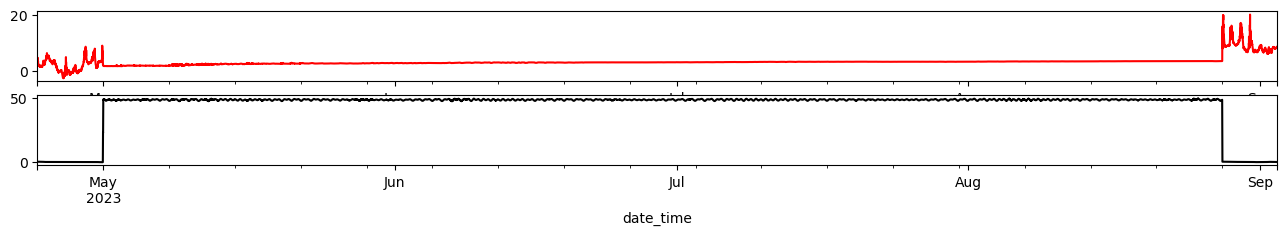

In [7]:
fig, ax = plt.subplots(2,figsize=(16, 2))
sbe39_wop_data.temperature.plot(ax=ax[0],color='r')
try:
    sbe39_wop_data.pressure.plot(ax=ax[1],color='k')
except:
    pass

## Add Deployment meta information

Two methods are available (if comming from python2 world - ordereddict was important... in py38 a dictionary is inherently ordered)

In [8]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [9]:
#Generates an ordereddict but prints better for summary
#likely to be depricated as an ordered dict may not be useful and drops a dependency if its EOL
mooring_config_v2 = load_config.load_config(mooring_meta_file)

In [10]:
mooring_config['Instrumentation'][instrument]

{'InstType': 'SBE-39',
 'SerialNo': '1635',
 'DesignedDepth': 50.0,
 'ActualDepth': 48.0,
 'PreDeploymentNotes': 'Li Batt, w/P',
 'PostDeploymentNotes': '',
 'Deployed': 'y',
 'Recovered': ''}

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [11]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)
inst_config

{'time': {'epic_key': 'TIM_601',
  'name': 'time',
  'generic_name': 'time',
  'standard_name': 'time',
  'long_name': 'date and time since reference time'},
 'depth': {'epic_key': 'D_3',
  'generic_name': 'depth',
  'units': 'meter',
  'long_name': 'depth below surface (meters)',
  'standard_name': 'depth',
  'positive': 'down'},
 'latitude': {'epic_key': 'LON_501',
  'name': 'latitude',
  'generic_name': 'latitude',
  'units': 'degrees_north',
  'long_name': 'latitude',
  'standard_name': 'latitude'},
 'longitude': {'epic_key': 'LAT_500',
  'name': 'longitude',
  'generic_name': 'longitude',
  'units': 'degrees_east',
  'long_name': 'longitude',
  'standard_name': 'longitude'},
 'timeseries_id': {'cf_role': 'timeseries_id',
  'long_name': 'timeseries id',
  'standard_name': ''},
 'temperature': {'epic_key': 'T_20',
  'generic_name': 'temp',
  'long_name': 'Sea temperature in-situ ITS-90 scale',
  'standard_name': 'sea_water_temperature',
  'units': 'degree_C'},
 'pressure': {'epic_ke

In [12]:
#just a dictionary of dictionaries - simple
with open(institution_meta_file) as file:
    institution_config = yaml.full_load(file)

In [13]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
sbe39_wop_nc = ncCFsave.EcoFOCI_CFnc(df=sbe39_wop_data, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config, 
                                operation_type='mooring',
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
sbe39_wop_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [14]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
sbe39_wop_nc.expand_dimensions()

In [15]:
sbe39_wop_nc.variable_meta_data(variable_keys=list(sbe39_wop_data.columns.values),drop_missing=True)
sbe39_wop_nc.temporal_geospatioal_meta_data(depth='actual')
#adding dimension meta needs to come after updating the dimension values... BUG?
sbe39_wop_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [16]:
#add global attributes
sbe39_wop_nc.deployment_meta_add()
sbe39_wop_nc.get_xdf()

#add instituitonal global attributes
sbe39_wop_nc.institution_meta_add(institution_yaml=institution_config)

#add instrument global attributes
sbe39_wop_nc.instrument_meta_data()

#add creation date/time - provenance data
sbe39_wop_nc.provinance_meta_add()

#provide intial qc status field
sbe39_wop_nc.qc_status(qc_status='unknown')

## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [17]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)

depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+depth+'m.nc'
sbe39_wop_nc.xarray2netcdf_save(xdf = sbe39_wop_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")

# don't trim the data and pass your own filename
# sbe39_wop_nc.xarray2netcdf_save(xdf = sbe39_wop_nc.get_xdf(),
#                            filename=filename,format="NETCDF4_CLASSIC")

In [18]:
sbe39_wop_nc.autotrim_time()

<xarray.Dataset>
Dimensions:      (time: 17138, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time         (time) datetime64[ns] 2023-04-30T23:50:00 ... 2023-08-28
  * latitude     (latitude) float64 56.86
  * longitude    (longitude) float64 -164.1
  * depth        (depth) float64 48.0
Data variables:
    temperature  (time, depth, latitude, longitude) float64 1.963 1.658 ... 3.43
    pressure     (time, depth, latitude, longitude) float64 38.65 ... 48.45
Attributes: (12/33)
    Latitude_DegMMddW:                      56 51.786 N
    Longitude_DegMMddN:                     164 3.034 W
    MooringID:                              23BS-2A
    platform_deployment_date:               2023-04-30T23:50:00Z
    platform_deployment_cruise_name:        DY2306
    platform_recovery_date:                 2023-08-28T00:00:00Z
    ...                                     ...
    InstrumentSerialNumber:                 1635
    InstrumentType:                         SBE-39
    date_created:                           2023-10-12T16:42:44Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

In [19]:
try:
    print(sbe39_wop_nc.autotrim_time().pressure.mean())
except:
    print(f'likely no pressure variable in datafile')

<xarray.DataArray 'pressure' ()>
array(48.49414955)


/Users/bell/Programs/ECOFOCI_Processing_Archive/settings/mpl_plot_settings.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


<Figure size 640x480 with 0 Axes>

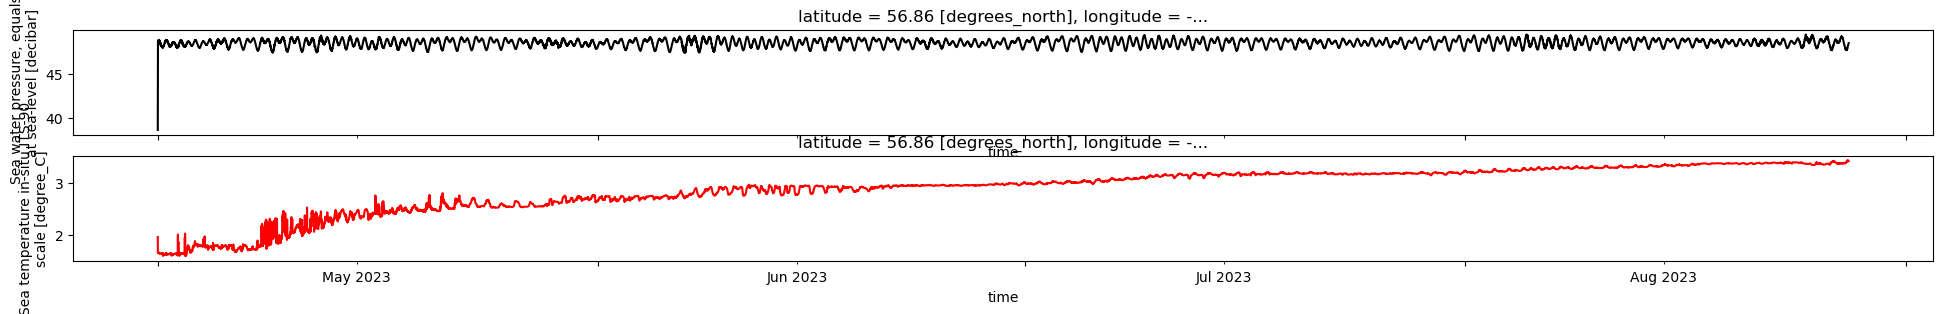

In [20]:
#wrap the plot in image settings for visual appeal
# may be able to make this cleaner or just a preset
%run '../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

fig, ax = plt.subplots(2,figsize=(24, 3), sharex=True)
sbe39_wop_nc.autotrim_time().temperature.plot(ax=ax[1],color='r')
try:
    sbe39_wop_nc.autotrim_time().pressure.plot(ax=ax[0],color='k')
except:
    pass


# xfmt = mdates.DateFormatter('%d-%b')
ax[1].xaxis.set_major_locator(DayLocator(bymonthday=1))
ax[1].xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax[1].xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax[1].xaxis.set_major_formatter(DateFormatter(''))
ax[1].xaxis.set_tick_params(which='major', pad=3)
ax[1].xaxis.set_tick_params(which='minor', pad=5)

In [21]:
#csvoutput if necessary
(sbe39_wop_nc.get_xdf().to_dataframe()).to_csv(filename.replace('nc','csv'))

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

**no pressure var - so assume pressure correction from other depths**

## QC plotting against CTDs (here or in a seperate ipynb)

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import EcoFOCIpy.io.erddap as erddap

url = "http://ecofoci-field.pmel.noaa.gov:8082/erddap"

# erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [23]:
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2306',qclevel='preliminary',concastno='066')
reccast = erddap.erddapCTDretrieve(url=url,cruiseid='aq2301',qclevel='preliminary',concastno='009')

some variable names switch between preliminary and final... this will eventually be resolved

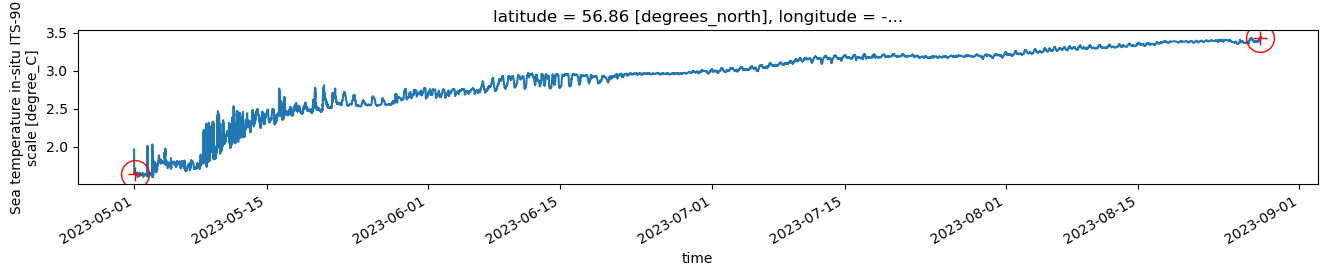

In [24]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(1,figsize=(16, 2))
sbe39_wop_nc.autotrim_time().temperature.plot(x="time",hue="depth",ax=ax, add_legend=False);
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
        reccast[reccast['pressure'] == depth]['T_28 (degree_C)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
        reccast[reccast['pressure'] == depth]['T_28 (degree_C)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['T_28 (degree_C)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['T_28 (degree_C)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

fig.savefig(f"images/{filename.replace('nc','_tempCal.png')}")